<a href="https://colab.research.google.com/github/ifeeney/On-Device-DL/blob/main/Evaluate_and_convert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Label Keys


0. Doing other things
1. Drumming Fingers
2. No Gesture
3. Pulling Hand In
4. Pulling Two Fingers In
5. Pushing Hand Away
6. Pushing Two Fingers Away
7. Rolling Hand Backward
8. Rolling Hand Forward
9. Shaking Hand
10. Sliding Two Fingers Down
11. Sliding Two Fingers Left
12. Sliding Two Fingers Up
13. Sliding Two Fingers Up
14. Stop Sign
15. Swiping Down
16. Swiping Left
17. Swiping Right
18. Swiping Up
19. Thumb Down
20. Thumb Up
21. Turning Hand Clockwaise
22. Turning Hand Counterclockwise
23. Zoomig In With Full Hand
24. Zooming In With Two Fingers
25. Zooming Out With Full Hand
26. Zooming Out With Two Fingers

In [1]:
import tensorflow as tf
import keras
from keras import layers

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model('bellas_model3.h5')

# Show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 37, 128)           98304     
                                                                 
 lstm_1 (LSTM)               (None, 37, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 27)                891       
                                                                 
Total params: 286427 (1.09 MB)
Trainable params: 286427 

In [2]:
import pickle

with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

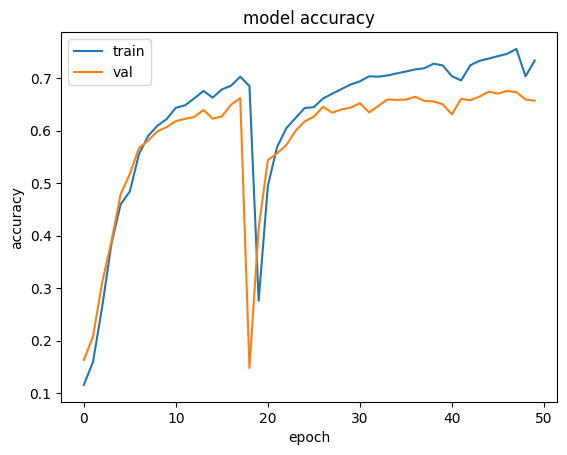

In [4]:
from matplotlib import pyplot as plt

plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

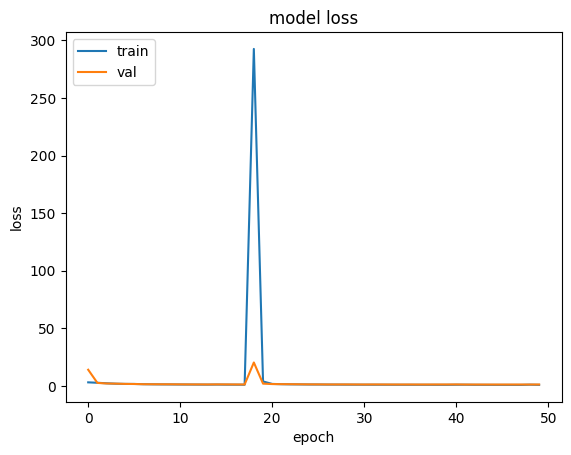

In [5]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
import numpy as np

def load_val():
    loadedArr = np.loadtxt("processed__val_sequence.csv")
    loadedArr2 = np.loadtxt("processed__val_labels.csv")
    # This loadedArr is a 2D array, therefore we need to convert it to the original array shape.
    # reshaping to get original matrice with original shape.
    loadedOriginal = loadedArr.reshape(loadedArr.shape[0], loadedArr.shape[1] // 63, 63)
    return loadedOriginal, loadedArr2

X_test, y_test = load_val()

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
220/220 [==============================] - 12s 50ms/step - loss: 1.1696 - categorical_accuracy: 0.6574
test loss, test acc: [1.169578194618225, 0.6573863625526428]


In [19]:
# Compare against first iteration
model = tf.keras.models.load_model('bellas_model.h5')
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results1 = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results1)

Evaluate on test data
220/220 [==============================] - 9s 37ms/step - loss: 1.3034 - categorical_accuracy: 0.6746
test loss, test acc: [1.303442358970642, 0.6745738387107849]


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:10])
print("predictions shape:", predictions.shape)
print(tf.argmax(predictions, axis=-1))
print(tf.argmax((y_test[:10]), axis=-1))

Generate predictions for 3 samples
1/1 [==============================] - 0s 425ms/step
predictions shape: (10, 27)
tf.Tensor([ 2  5 25 19 17 16  1 19 25 26], shape=(10,), dtype=int64)
tf.Tensor([23 15  9 19 17 25  1 19 25 26], shape=(10,), dtype=int64)


# Convert to tf lite model

Also important is to highlight the TensorFlow Lite’s LSTM contract with respect to the Keras operation definition:

The dimension 0 of the input tensor is the batch size.
The dimension 0 of the recurrent_weight tensor is the number of outputs.
The weight and recurrent_kernel tensors are transposed.
The transposed weight, transposed recurrent_kernel and bias tensors are split into 4 equal sized tensors along the dimension 0. These correspond to input gate, forget gate, cell, and output gate.


In [23]:
run_model = tf.function(lambda x: model(x))

# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 37
INPUT_SIZE = 63
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

# Save the model.
with open('bellas_model2.tflite', 'wb') as f:
  f.write(tflite_model)

In [22]:
import numpy as np

# Run the model with TensorFlow to get expected results.
TEST_CASES = 10

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
  expected = model.predict(X_test[i:i+1])
  interpreter.set_tensor(input_details[0]["index"], np.float32(X_test[i:i+1, :, :]))
  interpreter.invoke()
  result = interpreter.get_tensor(output_details[0]["index"])

  # Assert if the result of TFLite model is consistent with the TF model.
  np.testing.assert_almost_equal(expected, result, decimal=5)
  print("Done. The result of TensorFlow matches the result of TensorFlow Lite.")

  # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
  # the states.
  # Clean up internal states.
  interpreter.reset_all_variables()

1/1 [==============================] - 0s 29ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 30ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 28ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 34ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 28ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 39ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 40ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [==============================] - 0s 61ms/step
Done. The result of TensorFlow matches the result of TensorFlow Lite.
1/1 [===================